### Sparseness analysis of argo data

In [25]:
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#BASICS
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
#CARTOPY
import cartopy.geodesic
geod = cartopy.geodesic.Geodesic()
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])
#MATPLOTLIB
import matplotlib.pyplot as plt
#GRID
from scipy.interpolate import griddata
# NEARNEIGHBOR SCIKIT-LEARN
from sklearn.neighbors import NearestNeighbors

In [2]:
# Distance calculation fonction with cartopy geodesic
def dist(p1,p2):
    d,a1,a2 = np.array(geod.inverse(p1,p2).T)
    return d[0]/1000.0

#### First we read our data = argo profiles index, and make it a pandas dataframe

In [3]:
DAT=pd.read_csv('/home/oo26/coriolis/co05/co0508/ar_index_global_prof.txt',sep=',', index_col=None, 
                  header=0, skiprows=8,parse_dates=[1, 7])
# DAT=pd.read_csv('ftp://ftp.ifremer.fr/ifremer/argo/ar_index_global_prof.txt',sep=',', index_col=None, 
#                   header=0, skiprows=8,parse_dates=[1, 7])

#### Then we do some stuff with the dataframe

In [5]:
# GENERATE FLOAT NUMBER FROM FILE
DAT['FloatNumber'] = DAT.file.apply(lambda x: int(x.split('/')[1]))
#LAST PROFILE OF ACTIVE FLOATS
LDAT=DAT.groupby('FloatNumber').last()
ADAT=LDAT[LDAT.date > np.datetime64('2019-12-10')]
ADAT=ADAT[~ADAT.latitude.isnull() & ~ADAT.longitude.isnull()]
ADAT=ADAT.query('longitude >= -180 & longitude <= 180 & latitude >= -90 & latitude <= 90')

#### We calculate the distance between a float and its 4 neighbors (scikit learn lib)

In [6]:
#CURRENT ACTIVE PROFILES 
points = list(zip(ADAT['longitude'].values,ADAT['latitude'].values))
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(points)
indices = nbrs.kneighbors(points,return_distance=False)

distancem=np.empty_like(indices)
distances=np.empty(len(ADAT))
dtot=0;
for i in range(indices.shape[0]):
    di=0
    for j in [1,2,3,4]:
        distancem[i,j]=dist(np.array([ADAT['longitude'].values[i],ADAT['latitude'].values[i]]),
                            np.array([ADAT['longitude'].values[indices[i,j]],ADAT['latitude'].values[indices[i,j]]]))
        di+=distancem[i,j]
    di=di/4
    distances[i]=di
    dtot+=di    
dtot=dtot/len(ADAT)    
print("Average distance from a float to its closest buddy :",dtot," km")

Average distance from a float to its closest buddy : 237.6776282051282  km


#### Then we grid those distances over an area

In [56]:
x = np.arange(-180,181,1.0)
y = np.arange(-70,80,1.0)
grid_x, grid_y = np.meshgrid(x, y)
grid_z=griddata((ADAT['longitude'].values,ADAT['latitude'].values),distances,(grid_x,grid_y),method='cubic')

#### Here we retrieve cells (3x3°) where there are no data, to hide them in the plot 

In [104]:
bx = np.arange(-180,180,3.0)
by = np.arange(-70,80,3.0)
H1, xedges, yedges=np.histogram2d(ADAT['longitude'].values,ADAT['latitude'].values,bins=(bx,by))
G1=np.empty_like(H1)*np.nan
for i in range(H1.shape[0]):
    for j in range(H1.shape[1]):
        if H1[i,j]==0. :
            G1[i,j]=1              

#### and we plot

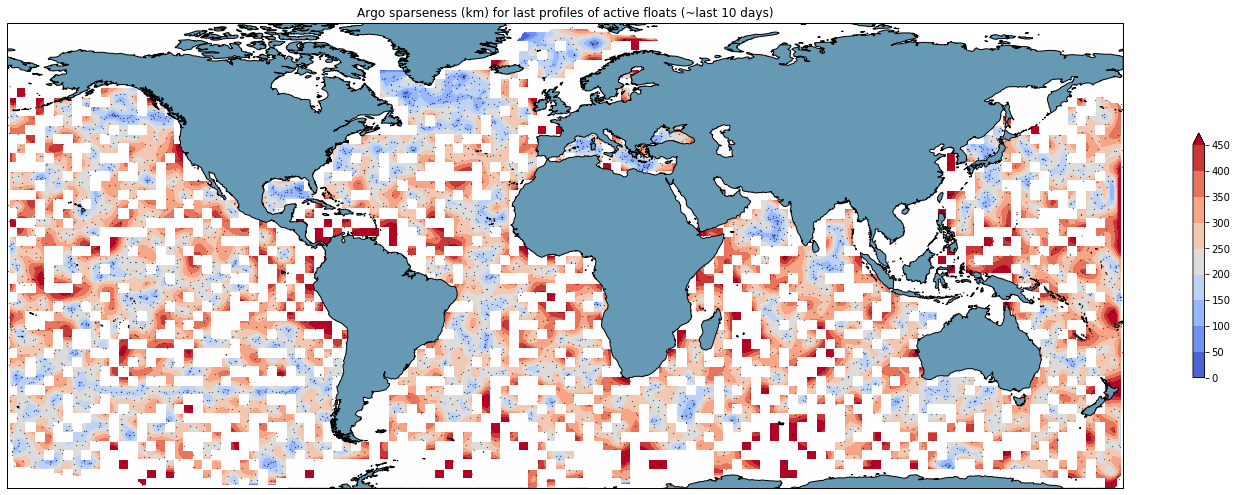

In [115]:
fig=plt.figure(figsize=(25,15))
pr1=ccrs.PlateCarree()
pr2=ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=pr2)
hh=ax.contourf(grid_x,grid_y,grid_z,np.arange(0,500,50),cmap='coolwarm',extend='max',transform=pr1)
ax.add_feature(land_feature, edgecolor='black')
plt.colorbar(hh,orientation= 'vertical', shrink=0.3, pad=0.05)
ax.pcolormesh(bx[0:-1],by[0:-1],G1.T,cmap='bwr',vmin=0.,vmax=2.,transform=pr1)
ax.plot(ADAT['longitude'].values,ADAT['latitude'].values,'k.',markersize=0.5,transform=pr1)
ax.set_extent([-180, 180, -70, 80], crs=pr1)
plt.title('Argo sparseness (km) for last profiles of active floats (~last 10 days)')
plt.show()

### SAME FOR ANOTHER SET OF DATA

In [10]:
YY=datetime.today().year
MM=datetime.today().month
if MM==1:
    PM=12
    PY=YY-1
else:
    PM=MM-1
    PY=YY

In [24]:
#ANOTHER TIME SELECTION
tquery='date >= "'+str(PY)+'-'+str(PM)+'" & date < "'+str(YY)+'-'+str(MM)+'"'
print(tquery)
MDAT=DAT.query(tquery)
MDAT=MDAT[~MDAT.latitude.isnull() & ~MDAT.longitude.isnull()]
MDAT=MDAT.query('longitude >= -180 & longitude <= 180 & latitude >= -90 & latitude <= 90')
MDAT.head()

date >= "2019-12" & date < "2020-1"


,file,date,latitude,longitude,ocean,profiler_type,institution,date_update
67933,aoml/1900978/profiles/R1900978_370.nc,2019-12-03 11:32:25,-59.307,-100.536,P,846,AO,2019-12-04 02:04:16
67934,aoml/1900978/profiles/R1900978_371.nc,2019-12-14 05:07:15,-58.921,-100.889,P,846,AO,2019-12-14 19:05:00
67935,aoml/1900978/profiles/R1900978_372.nc,2019-12-24 17:30:35,-59.172,-100.616,P,846,AO,2019-12-27 02:05:36
68306,aoml/1900979/profiles/R1900979_370.nc,2019-12-03 21:57:23,-43.633,139.860,I,846,AO,2019-12-04 19:05:23
68307,aoml/1900979/profiles/R1900979_371.nc,2019-12-14 12:50:01,-43.324,139.416,I,846,AO,2019-12-15 09:05:11


In [117]:
#NEARNEIGHBOR
points = list(zip(MDAT['longitude'].values,MDAT['latitude'].values))
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(points)
indices = nbrs.kneighbors(points,return_distance=False)

distancem=np.empty_like(indices)
distances2=np.empty(len(MDAT))
dtot=0;
for i in range(indices.shape[0]):
    di=0
    for j in [1,2,3,4]:
        distancem[i,j]=dist(np.array([MDAT['longitude'].values[i],MDAT['latitude'].values[i]]),
                            np.array([MDAT['longitude'].values[indices[i,j]],MDAT['latitude'].values[indices[i,j]]]))
        di+=distancem[i,j]
    di=di/4.0
    distances2[i]=di
    dtot+=di    
dtot=dtot/len(MDAT)    
print("Average distance from a float to its closest buddy :",dtot," km")

Average distance from a float to its closest buddy : 78.44534506716072  km


In [75]:
grid_z2=griddata((MDAT['longitude'].values,MDAT['latitude'].values),distances2,(grid_x,grid_y),method='cubic')

In [76]:
H2, xedges, yedges=np.histogram2d(MDAT['longitude'].values,MDAT['latitude'].values,bins=(bx,by))
G2=np.empty_like(H2)*np.nan
for i in range(H2.shape[0]):
    for j in range(H2.shape[1]):
        if H2[i,j]==0. :
            G2[i,j]=1  

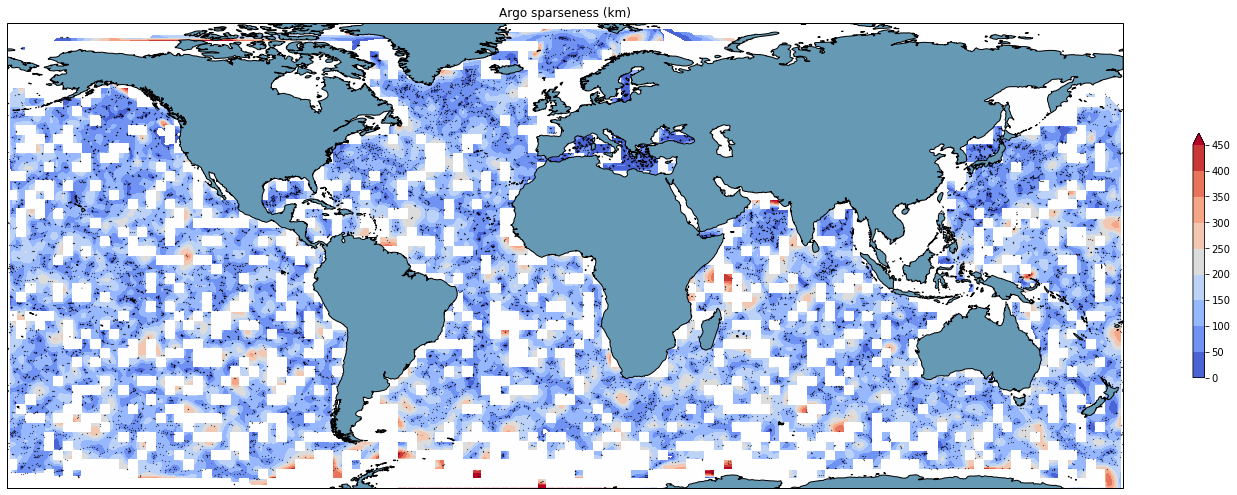

In [116]:
fig=plt.figure(figsize=(25,15))
pr1=ccrs.PlateCarree()
pr2=ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=pr2)
hh=ax.contourf(grid_x,grid_y,grid_z2,np.arange(0,500,50),cmap='coolwarm',extend='max',transform=pr1)
ax.add_feature(land_feature, edgecolor='black')
plt.colorbar(hh,orientation= 'vertical', shrink=0.3, pad=0.05)
ax.pcolormesh(bx[0:-1],by[0:-1],G2.T,cmap='bwr',vmin=0.,vmax=2.,transform=pr1)
ax.plot(MDAT['longitude'].values,MDAT['latitude'].values,'k.',markersize=0.5,transform=pr1)
ax.set_extent([-180, 180, -70, 80], crs=pr1)
plt.title('Argo sparseness (km)')
plt.show()

### AUTRE APPROCHE POUR UNE CARTE COMPLETE DE SPARSENESS
#### ON APPELLE NEARNEIGHBORS POUR TOUS LES POINTS D'UNE GRILLE sx,sy

In [26]:
sx = np.arange(-180,180,1./4)
sy = np.arange(-70,80,1./4)
#pour que scikit nearneighbors les ingère, on les passe en serie de points
search_points = np.array(list(itertools.product(sx, sy)))

In [27]:
#NEARNEIGHBOR
points = list(zip(MDAT['longitude'].values,MDAT['latitude'].values))
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(points)
inds = nbrs.kneighbors(search_points,return_distance=False)

mdist=np.empty(len(search_points))
for i in range(inds.shape[0]):
    di=0
    for j in [1,2,3,4]:
        d_temp=dist(np.array([search_points[i,0],search_points[i,1]]),
                    np.array([MDAT['longitude'].values[inds[i,j]],MDAT['latitude'].values[inds[i,j]]]))
        di+=d_temp
    di=di/4.0
    mdist[i]=di
    
grid_sx, grid_sy = np.meshgrid(sx, sy)
grid_sz=griddata((search_points[:,0],search_points[:,1]),mdist,(grid_sx,grid_sy),method='cubic')    

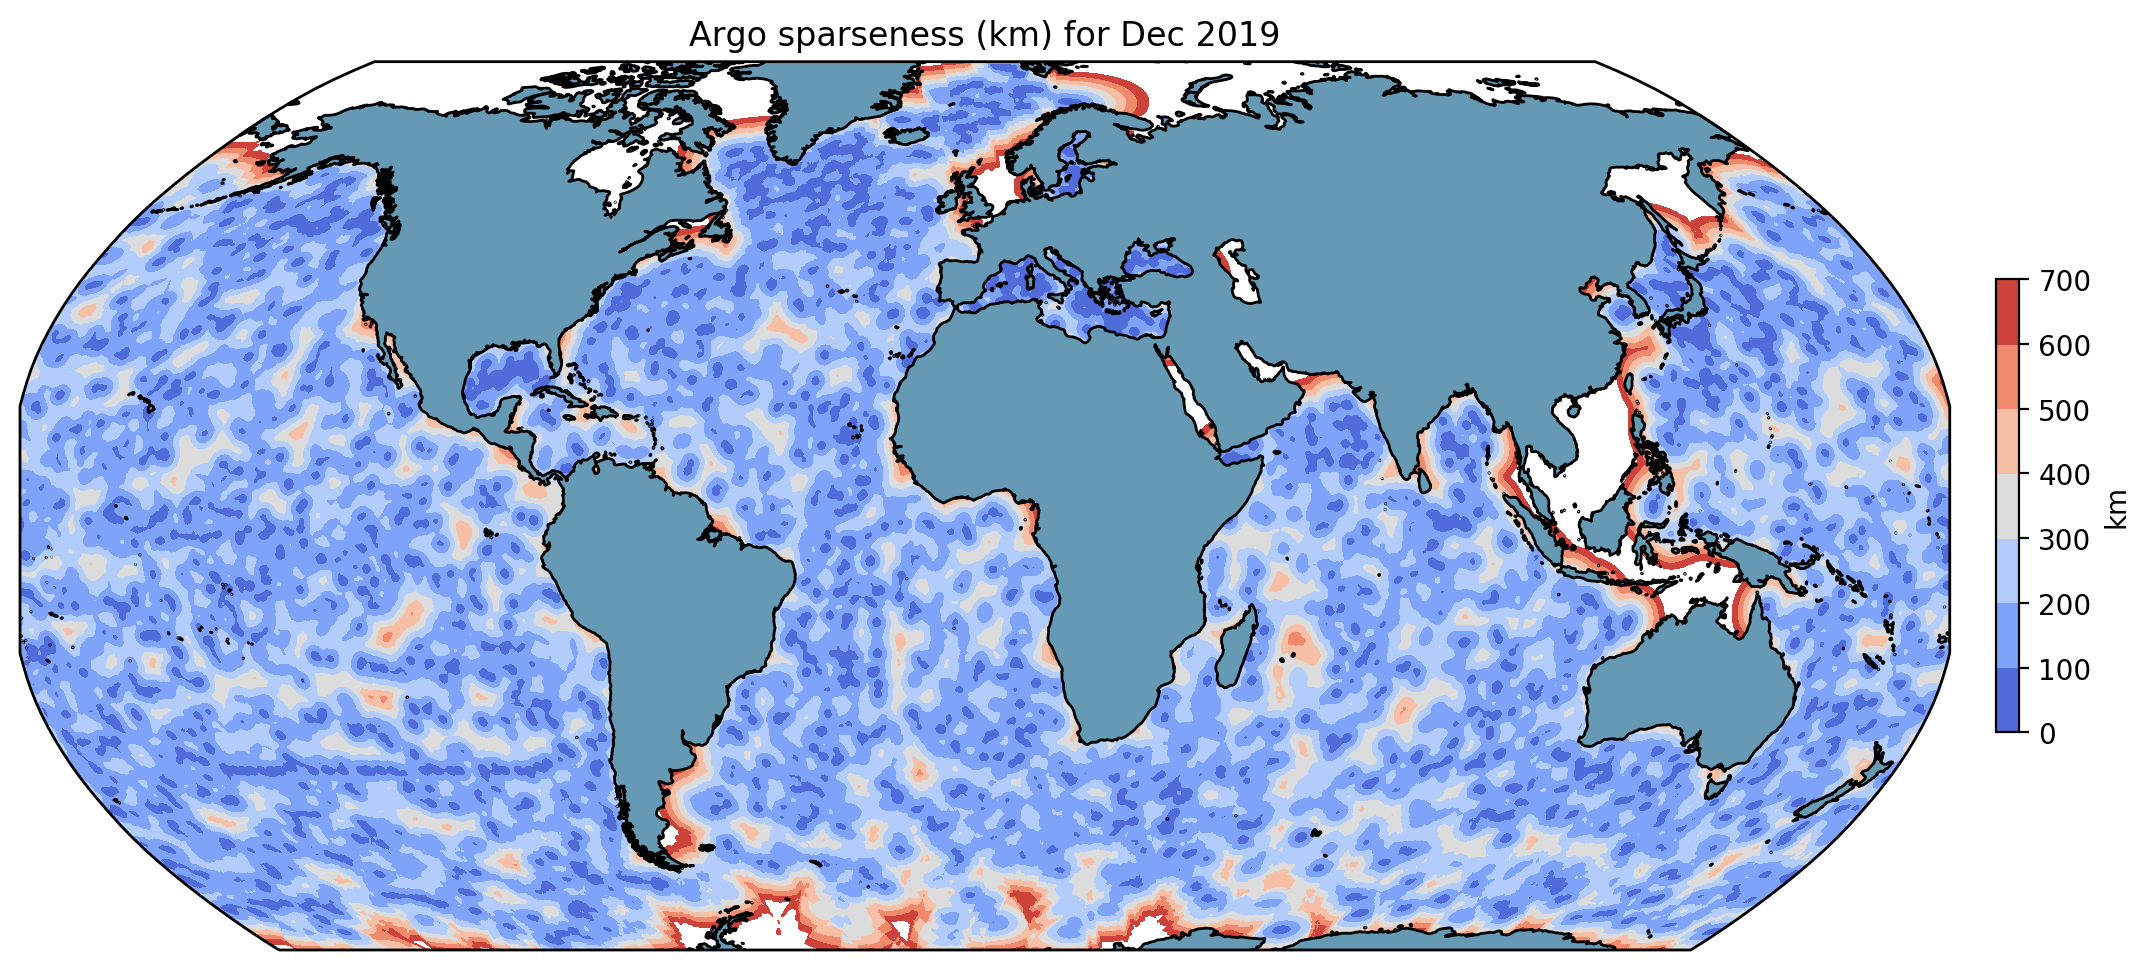

In [42]:
fig=plt.figure(figsize=(15,10),dpi=200)
pr1=ccrs.PlateCarree()
pr2=ccrs.Robinson()
ax = fig.add_subplot(1, 1, 1, projection=pr2)
hh=ax.contourf(grid_sx,grid_sy,grid_sz,np.arange(0,800,100),cmap='coolwarm',extend='neither',transform=pr1)
ax.add_feature(land_feature, edgecolor='black')
cbar=plt.colorbar(hh,orientation= 'vertical', shrink=0.3, pad=0.02)
cbar.set_label('km')
ax.set_extent([-180, 180, -70, 80], crs=pr1)
plt.title('Argo sparseness (km) for Dec 2019')
plt.show()
fig.savefig('PNG/Last.png',dpi=200,facecolor='w',edgecolor='none',bbox_inches='tight', pad_inches=0.1)

In [189]:
# AUTRE TIME SELECTION

#NEARNEIGHBOR
points = list(zip(ADAT['longitude'].values,ADAT['latitude'].values))
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(points)
inds = nbrs.kneighbors(search_points,return_distance=False)

mdist=np.empty(len(search_points))
for i in range(inds.shape[0]):
    di=0
    for j in [1,2,3,4]:
        d_temp=dist(np.array([search_points[i,0],search_points[i,1]]),
                    np.array([ADAT['longitude'].values[inds[i,j]],ADAT['latitude'].values[inds[i,j]]]))
        di+=d_temp
    di=di/4.0
    mdist[i]=di
    
grid_sx, grid_sy = np.meshgrid(sx, sy)
grid_sz=griddata((search_points[:,0],search_points[:,1]),mdist,(grid_sx,grid_sy),method='cubic')    

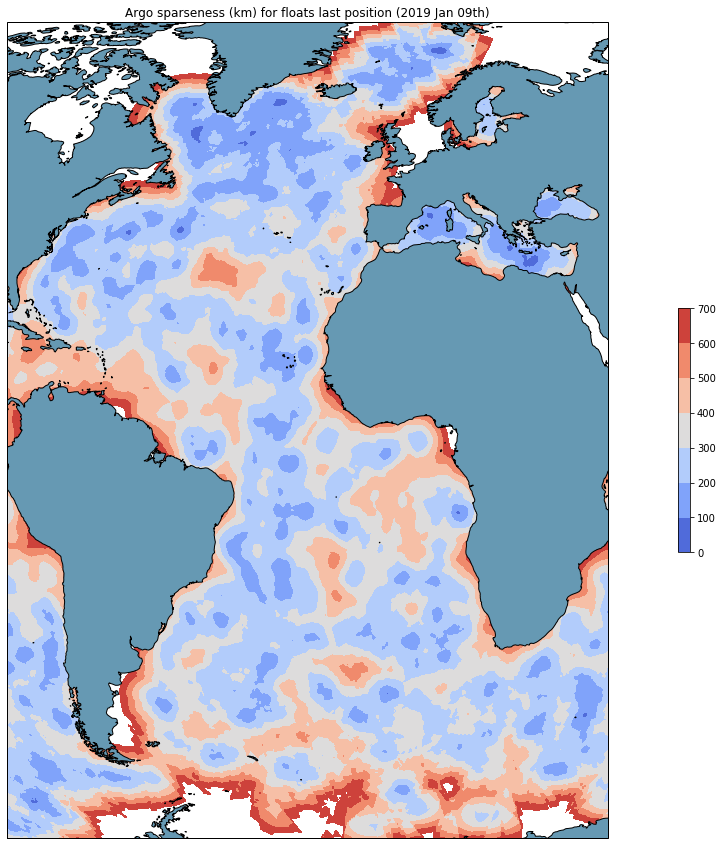

In [194]:
fig=plt.figure(figsize=(25,15))
pr1=ccrs.PlateCarree()
pr2=ccrs.Robinson()
ax = fig.add_subplot(1, 1, 1, projection=pr2)
hh=ax.contourf(grid_sx,grid_sy,grid_sz,np.arange(0,800,100),cmap='coolwarm',extend='neither',transform=pr1)
ax.add_feature(land_feature, edgecolor='black')
plt.colorbar(hh,orientation= 'vertical', shrink=0.3, pad=0.05)
ax.set_extent([-180, 180, -70, 80], crs=pr1)
plt.title('Argo sparseness (km) for floats last position (2019 Jan 09th)')
plt.show()